In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride= 1, padding= 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride= 1, padding= 2)
    
    def forward(self,x):
        residual  = torch.clone(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.conv2(self.activation2(self.bn2(x)))
        residual = residual.unsqueeze(0)
        residual = nn.functional.interpolate(residual, size = [x.shape[1], x.shape[2], x.shape[3]])
        residual = residual.squeeze(0)
        x += residual
        return x
     
class ModelSubDep(nn.Module):

    def __init__(self):
        super(ModelSubDep, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 5, out_channels = 62, kernel_size= 3, stride= 1, padding= 2)
        self.resblock1 = ResidualBlock(62,62,5)
        self.resblock2 = ResidualBlock(62,124,5)
        self.resblock3 = ResidualBlock(124,248,5)
        self.avgpool = nn.AdaptiveAvgPool2d((30,30))
        self.linear1 = nn.Linear(30*30*248, 1024)
        self.drop1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(512, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.avgpool(x)
        F = nn.Flatten()
        x = F(x)
        x = self.linear1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [3]:
import scipy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold as skf

class Dataset(Dataset):
    def __init__(self, data, info):
        #data loading
        self.x = data
        self.y = info
        self.n_samples = data.shape[0]


    def __getitem__(self,index):
        t1 = self.x[index]
        t2 = self.y[index]
        t1 = torch.tensor(t1)
        t1 = t1.permute((2,0,1))
        t2 = torch.tensor(t2)
        return (t1,t2)
    
    def __len__(self):
        return self.n_samples
    
data = scipy.io.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/DA-AFNet/datasets/SEED/SEED_5_3.mat')

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'coh', 'pli', 'psd', 'labels_kfold', 'valence', 'EEGNet', 'ni'])

In [5]:
x_c=data['coh']
x_p = data['pli']
x_d = data['psd']
labels_skf = data['labels_kfold']
labels_skf = labels_skf.transpose()
labels = data['valence']
ni = data['ni'][0]

In [6]:
# dt = data['data']
# labels_skf = data['labels_kfold']
# labels = data['valence']

In [7]:
labels_skf.shape

(15, 1)

In [8]:
x_c.shape

(15, 235, 62, 62, 5)

In [9]:
x_n = np.zeros((15, 235, 62, 62, 5))
for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        x_n[trial,sample,:,:,0] = x_c[trial,sample,:,:,0]+np.transpose(x_c[trial,sample,:,:,0])
        x_n[trial,sample,:,:,1] = x_c[trial,sample,:,:,1]+np.transpose(x_c[trial,sample,:,:,1])
        x_n[trial,sample,:,:,2] = x_c[trial,sample,:,:,2]+np.transpose(x_c[trial,sample,:,:,2])
        x_n[trial,sample,:,:,3] = x_c[trial,sample,:,:,3]+np.transpose(x_c[trial,sample,:,:,3])
        x_n[trial,sample,:,:,4] = x_c[trial,sample,:,:,4]+np.transpose(x_c[trial,sample,:,:,4])
    print(f'Completed trial {trial}')

for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        for i in range(62):
            x_n[trial,sample,i,i,:] = x_d[trial,sample,i,:]
    print(f'Completed trial {trial}')

Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed trial 13
Completed trial 14
Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed trial 13
Completed trial 14


In [10]:
labels_skf = labels_skf[ni]
labels_skf.shape

(10, 1)

In [11]:
labels_skf

array([[ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1]], dtype=int16)

In [12]:
v = labels_skf[:,0]
v[np.where(v == -1)[0]] = 0
l_skf = v[:,np.newaxis]

In [13]:
dt = x_n[ni]
labels = labels[ni]
trainLoss={}
valLoss = {}
trainAcc = {}
valAcc = {}

In [14]:
dt.shape

(10, 235, 62, 62, 5)

In [15]:
labels.shape

(10, 235, 2)

In [16]:
labels_skf.shape

(10, 1)

In [17]:
l_skf.shape

(10, 1)

In [18]:
dt.shape

(10, 235, 62, 62, 5)

In [19]:
kf = skf(n_splits = 5)
l = []
ind = []
for k,(train_index,test_index) in enumerate(kf.split(dt,l_skf[:,0])):
    print(train_index,test_index)
    labelsTr, labelsV = labels[train_index], labels[test_index]   
    l.append({'train': labelsTr,
            'valid': labelsV})
    ind.append([train_index,test_index])

[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


In [20]:
counts = []
for fold in range(len(l)):
    count_hv_t = 0
    count_lv_t = 0
    count_hv_v = 0
    count_lv_v = 0
    l_fold = l[fold]
    for label in l_fold['train']:
        if (label == [0.,1.]).all():
            count_hv_t += 1
        else:
            count_lv_t +=1
    for label in l_fold['valid']:
        if (label == [0.,1.]).all():
            count_hv_v += 1
        else:
            count_lv_v +=1
    counts.append([count_hv_t,count_lv_t,count_hv_v,count_lv_v])    
    print(f'Fold {fold} completed')




Fold 0 completed
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed


In [21]:
df = pd.DataFrame(data=counts, columns= ['hv_t','lv_t','hv_v','lv_v'])

In [22]:
print(df)

   hv_t  lv_t  hv_v  lv_v
0     4     4     1     1
1     4     4     1     1
2     4     4     1     1
3     4     4     1     1
4     4     4     1     1


<Axes: >

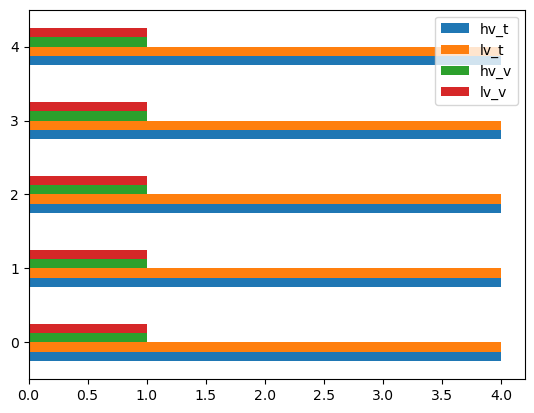

In [23]:
df.plot.barh()

In [24]:
l_skf

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0]], dtype=int16)

In [25]:
dt.shape

(10, 235, 62, 62, 5)

In [26]:
labels.shape

(10, 235, 2)

In [27]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha, gamma):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         weights = [self.alpha[t] for t in targets]
#         weights = torch.tensor(np.array(weights))
#         weights = weights.to('cuda')
#         loss = (weights* (1 - pt) ** self.gamma * ce_loss).mean()
#         return loss

In [28]:
from focal_loss.focal_loss import FocalLoss

In [29]:
kf = skf(n_splits = 5)
log_pred_dict = {}
for k,(train_index,test_index) in enumerate(kf.split(dt, l_skf)):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Fold {k+1} running')
    dataTr, dataV = np.concatenate(dt[train_index],0), np.concatenate(dt[test_index],0)
    labelsTr, labelsV = np.concatenate(labels[train_index],0), np.concatenate(labels[test_index],0)
    tL = []
    vL = []
    tAV = []
    vAV = []
    y_train = np.argmax(labelsTr, axis=1)
    class_counts = np.bincount(y_train)
    num_classes = len(class_counts)
    total_samples = len(y_train)

    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    weights = torch.tensor(np.array(class_weights))
    weights = weights.to(device)
    # testAC = []
    model = ModelSubDep()
    model = model.to(device)
     # Define your weights as a tensor
    criterion1 = nn.CrossEntropyLoss(weight=weights)
    optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum= 0.9)
    trainDS = Dataset(dataTr, labelsTr)
    trainDL = DataLoader(dataset = trainDS, batch_size = 100, shuffle = True)
 
    valDS = Dataset(dataV, labelsV)
    valDL = DataLoader(dataset = valDS, batch_size = 100, shuffle = True)
    
    testDS = Dataset(dataV, labelsV)
    testDL = DataLoader(dataset = testDS, batch_size = 100)
    num_epochs = 50
    batchsize = 100
    l2_lambda = 0.001
    best_acc = 0
    for epoch in range(num_epochs):
        trainAccuracy = 0
        totalLoss = 0
        with tqdm(trainDL, unit='batch') as tepoch:
            model.train()
            for imagest,lab in tepoch:
                imagest = imagest.to(device)
                lab = lab.to(device)
                optimizer_ft.zero_grad()
                outputs = (model(imagest.float()))
                _,predindex = torch.max(outputs, dim = 1)
                _,labindex = torch.max(lab, dim = 1)
                loss = criterion1(outputs,lab.float())
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2) # L2 norm of the parameter
                loss += l2_lambda * l2_reg
                loss.backward()
                optimizer_ft.step()
                totalLoss+=loss.item()
                acc = (predindex==labindex).sum().item()
                trainAccuracy += acc/(lab.shape[0]*len(trainDL))
                tepoch.set_postfix(loss=loss.item(),totalLoss =totalLoss/len(trainDL), TrainAccuracy= 100.*trainAccuracy)      
            model.eval()
            with torch.no_grad():
                with tqdm(valDL, unit='batch') as tepoch:
                    total = 0
                    valAccuracy = 0
                    val_loss = 0
                    for imagesv,labv in tepoch:
                        imagesv = imagesv.to(device)
                        labelsv = labv.to(device)
                        outval = (model(imagesv.float()))
                        _,predindexval = torch.max(outval,dim = 1)
                        _,labvalindex = torch.max(labelsv,dim = 1)
                        acc = (predindexval == labvalindex).sum().item()
                        valAccuracy +=acc/(labv.shape[0]*len(valDL))
                        lossv = criterion1(outval,labelsv.float())
                        val_loss+= lossv.item()
                        tepoch.set_postfix(lossv=lossv.item(),valLoss =val_loss/len(valDL), ValAccuracy= 100.*valAccuracy)
        print('Epoch [{}], Loss_t: {:.4f},Loss_v: {:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'.format(epoch, totalLoss/len(trainDL), val_loss/len(valDL),
                                                                                                   100.*trainAccuracy,100.*valAccuracy))

        path = "./models_seed/model_best_"+str(epoch)+"_"+str(k)+"_"+str(100.*valAccuracy) 
        if trainAccuracy>best_acc:
            best_acc = trainAccuracy
            model_to_save = model
            path_to_save = path
        
        tL.append(totalLoss/len(trainDL))
        vL.append(val_loss/len(valDL))
        tAV.append(100.*trainAccuracy)
        vAV.append( 100.*valAccuracy)
    # torch.save(model_to_save.state_dict(), path_to_save)
    trainLoss[str(k)] = tL
    valLoss[str(k)] = vL
    trainAcc[str(k)] = tAV
    valAcc[str(k)] = vAV
    model.eval()
    pt = []
    lt = []
    with torch.no_grad():
        with tqdm(testDL, unit='batch') as tepochtst:
            for imagestst,labt in tepochtst:
                imagestst = imagestst.to(device)
                labelst = labt.to(device)
                outt = (model(imagestst.float()))
                _,predt = torch.max(outt,dim=1)
                _,labti = torch.max(labelst,dim =1)
                pt.append(predt)
                lt.append(labti)
    log_pred_dict[str(k)] = {'trails': test_index,
                             'predicted': pt,
                             'ground truth': lt}
tL = np.array(list(trainLoss.values()))
vL = np.array(list(valLoss.values()))
tAV = np.array(list(trainAcc.values()))
vAV = np.array(list(valAcc.values()))

Fold 1 running


100%|██████████| 5/5 [00:01<00:00,  3.49batch/s, ValAccuracy=85.8, lossv=1.35, valLoss=1.35] 


Epoch [0], Loss_t: 1.4944,Loss_v: 1.3498, train_acc:59.0658, val_acc:85.8000


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=91, lossv=1.18, valLoss=1.17]   


Epoch [1], Loss_t: 1.3928,Loss_v: 1.1681, train_acc:73.2368, val_acc:91.0000


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=96.7, lossv=0.987, valLoss=0.994]


Epoch [2], Loss_t: 1.3168,Loss_v: 0.9942, train_acc:77.2895, val_acc:96.7143


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=86.3, lossv=0.958, valLoss=0.975]


Epoch [3], Loss_t: 1.2590,Loss_v: 0.9751, train_acc:78.3421, val_acc:86.3143


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=94.3, lossv=0.91, valLoss=0.889] 


Epoch [4], Loss_t: 1.2174,Loss_v: 0.8890, train_acc:80.0921, val_acc:94.2571


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=96.2, lossv=0.868, valLoss=0.852]


Epoch [5], Loss_t: 1.1861,Loss_v: 0.8521, train_acc:81.0789, val_acc:96.1714


100%|██████████| 5/5 [00:01<00:00,  3.60batch/s, ValAccuracy=93.3, lossv=0.854, valLoss=0.867]


Epoch [6], Loss_t: 1.1534,Loss_v: 0.8670, train_acc:82.4211, val_acc:93.2571


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=90.1, lossv=0.905, valLoss=0.878]


Epoch [7], Loss_t: 1.1320,Loss_v: 0.8779, train_acc:83.1447, val_acc:90.1143


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=97.5, lossv=0.77, valLoss=0.791] 


Epoch [8], Loss_t: 1.1203,Loss_v: 0.7912, train_acc:83.9868, val_acc:97.5143


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=86.3, lossv=0.884, valLoss=0.907]


Epoch [9], Loss_t: 1.0898,Loss_v: 0.9065, train_acc:86.0789, val_acc:86.3143


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=97.3, lossv=0.788, valLoss=0.771]


Epoch [10], Loss_t: 1.0734,Loss_v: 0.7705, train_acc:86.5263, val_acc:97.3143


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=89.6, lossv=0.826, valLoss=0.867]


Epoch [11], Loss_t: 1.0599,Loss_v: 0.8670, train_acc:87.4342, val_acc:89.5714


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=88, lossv=0.882, valLoss=0.887]


Epoch [12], Loss_t: 1.0494,Loss_v: 0.8871, train_acc:87.3026, val_acc:88.0000


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=97.5, lossv=0.745, valLoss=0.75] 


Epoch [13], Loss_t: 1.0296,Loss_v: 0.7497, train_acc:88.8553, val_acc:97.5143


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=92.5, lossv=0.874, valLoss=0.836]


Epoch [14], Loss_t: 1.0238,Loss_v: 0.8356, train_acc:88.8684, val_acc:92.5143


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=92.6, lossv=0.831, valLoss=0.836]


Epoch [15], Loss_t: 1.0025,Loss_v: 0.8355, train_acc:90.0395, val_acc:92.5714


100%|██████████| 5/5 [00:01<00:00,  3.53batch/s, ValAccuracy=89.9, lossv=0.978, valLoss=0.864]


Epoch [16], Loss_t: 0.9930,Loss_v: 0.8636, train_acc:90.1842, val_acc:89.8857


100%|██████████| 5/5 [00:01<00:00,  3.54batch/s, ValAccuracy=91.8, lossv=0.795, valLoss=0.846]


Epoch [17], Loss_t: 0.9827,Loss_v: 0.8458, train_acc:91.1974, val_acc:91.8286


100%|██████████| 5/5 [00:01<00:00,  3.54batch/s, ValAccuracy=96.2, lossv=0.777, valLoss=0.76] 


Epoch [18], Loss_t: 0.9748,Loss_v: 0.7604, train_acc:91.4079, val_acc:96.1714


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=91.3, lossv=0.927, valLoss=0.847]


Epoch [19], Loss_t: 0.9649,Loss_v: 0.8473, train_acc:91.9079, val_acc:91.2571


100%|██████████| 5/5 [00:01<00:00,  3.58batch/s, ValAccuracy=96.2, lossv=0.739, valLoss=0.754]


Epoch [20], Loss_t: 0.9580,Loss_v: 0.7537, train_acc:92.1842, val_acc:96.2286


100%|██████████| 5/5 [00:01<00:00,  3.46batch/s, ValAccuracy=95, lossv=0.735, valLoss=0.774]  


Epoch [21], Loss_t: 0.9500,Loss_v: 0.7741, train_acc:92.2895, val_acc:95.0286


100%|██████████| 5/5 [00:01<00:00,  3.56batch/s, ValAccuracy=89.7, lossv=0.917, valLoss=0.859]


Epoch [22], Loss_t: 0.9446,Loss_v: 0.8595, train_acc:92.7632, val_acc:89.6571


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=97.4, lossv=0.716, valLoss=0.714]


Epoch [23], Loss_t: 0.9391,Loss_v: 0.7137, train_acc:92.7368, val_acc:97.4286


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=91.4, lossv=0.838, valLoss=0.834]


Epoch [24], Loss_t: 0.9328,Loss_v: 0.8343, train_acc:93.3553, val_acc:91.4000


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=93.3, lossv=0.802, valLoss=0.804]


Epoch [25], Loss_t: 0.9212,Loss_v: 0.8039, train_acc:93.8947, val_acc:93.2571


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=93.6, lossv=0.773, valLoss=0.786]


Epoch [26], Loss_t: 0.9131,Loss_v: 0.7857, train_acc:94.5263, val_acc:93.6286


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=95.2, lossv=0.834, valLoss=0.746]


Epoch [27], Loss_t: 0.9133,Loss_v: 0.7460, train_acc:94.1447, val_acc:95.2286


100%|██████████| 5/5 [00:01<00:00,  3.56batch/s, ValAccuracy=95.7, lossv=0.794, valLoss=0.744]


Epoch [28], Loss_t: 0.9022,Loss_v: 0.7436, train_acc:95.2895, val_acc:95.6571


100%|██████████| 5/5 [00:01<00:00,  3.55batch/s, ValAccuracy=94.8, lossv=0.727, valLoss=0.76] 


Epoch [29], Loss_t: 0.8961,Loss_v: 0.7602, train_acc:95.1711, val_acc:94.8286


100%|██████████| 5/5 [00:01<00:00,  3.51batch/s, ValAccuracy=92.4, lossv=0.889, valLoss=0.808]


Epoch [30], Loss_t: 0.8931,Loss_v: 0.8084, train_acc:95.4342, val_acc:92.4286


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=95.1, lossv=0.735, valLoss=0.745]


Epoch [31], Loss_t: 0.8930,Loss_v: 0.7455, train_acc:94.9737, val_acc:95.0571


100%|██████████| 5/5 [00:01<00:00,  3.45batch/s, ValAccuracy=92.9, lossv=0.803, valLoss=0.798]


Epoch [32], Loss_t: 0.8812,Loss_v: 0.7978, train_acc:95.8684, val_acc:92.8571


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=95.4, lossv=0.749, valLoss=0.75] 


Epoch [33], Loss_t: 0.8773,Loss_v: 0.7505, train_acc:96.4474, val_acc:95.4286


100%|██████████| 5/5 [00:01<00:00,  3.46batch/s, ValAccuracy=93, lossv=0.806, valLoss=0.794]  


Epoch [34], Loss_t: 0.8711,Loss_v: 0.7935, train_acc:96.6711, val_acc:92.9714


100%|██████████| 5/5 [00:01<00:00,  3.50batch/s, ValAccuracy=95.4, lossv=0.771, valLoss=0.753]


Epoch [35], Loss_t: 0.8672,Loss_v: 0.7525, train_acc:96.4605, val_acc:95.3714


100%|██████████| 5/5 [00:01<00:00,  3.56batch/s, ValAccuracy=91.9, lossv=0.757, valLoss=0.804]


Epoch [36], Loss_t: 0.8666,Loss_v: 0.8042, train_acc:96.6579, val_acc:91.9429


100%|██████████| 5/5 [00:01<00:00,  3.55batch/s, ValAccuracy=95.8, lossv=0.823, valLoss=0.766]


Epoch [37], Loss_t: 0.8630,Loss_v: 0.7658, train_acc:96.7632, val_acc:95.7714


100%|██████████| 5/5 [00:01<00:00,  3.51batch/s, ValAccuracy=97.1, lossv=0.747, valLoss=0.717]


Epoch [38], Loss_t: 0.8607,Loss_v: 0.7171, train_acc:97.1842, val_acc:97.1429


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=91, lossv=0.795, valLoss=0.813]  


Epoch [39], Loss_t: 0.8535,Loss_v: 0.8129, train_acc:97.3947, val_acc:90.9714


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=90, lossv=0.811, valLoss=0.822]  


Epoch [40], Loss_t: 0.8477,Loss_v: 0.8220, train_acc:97.3289, val_acc:90.0000


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=93.3, lossv=0.829, valLoss=0.789]


Epoch [41], Loss_t: 0.8422,Loss_v: 0.7889, train_acc:97.6711, val_acc:93.3143


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=91.8, lossv=0.81, valLoss=0.803] 


Epoch [42], Loss_t: 0.8385,Loss_v: 0.8032, train_acc:97.6579, val_acc:91.8000


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=95.9, lossv=0.739, valLoss=0.747]


Epoch [43], Loss_t: 0.8334,Loss_v: 0.7471, train_acc:98.1579, val_acc:95.9429


100%|██████████| 5/5 [00:01<00:00,  3.60batch/s, ValAccuracy=94.1, lossv=0.707, valLoss=0.769]


Epoch [44], Loss_t: 0.8337,Loss_v: 0.7686, train_acc:97.9868, val_acc:94.1143


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=91.3, lossv=0.803, valLoss=0.803]


Epoch [45], Loss_t: 0.8311,Loss_v: 0.8029, train_acc:98.3026, val_acc:91.2857


100%|██████████| 5/5 [00:01<00:00,  3.53batch/s, ValAccuracy=91.8, lossv=0.795, valLoss=0.793]


Epoch [46], Loss_t: 0.8269,Loss_v: 0.7931, train_acc:98.3684, val_acc:91.8000


100%|██████████| 5/5 [00:01<00:00,  3.47batch/s, ValAccuracy=93.7, lossv=0.763, valLoss=0.777]


Epoch [47], Loss_t: 0.8267,Loss_v: 0.7773, train_acc:98.5263, val_acc:93.7429


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=90.9, lossv=0.766, valLoss=0.798]


Epoch [48], Loss_t: 0.8221,Loss_v: 0.7978, train_acc:98.6053, val_acc:90.8571


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=88.8, lossv=0.886, valLoss=0.825]


Epoch [49], Loss_t: 0.8204,Loss_v: 0.8248, train_acc:98.5658, val_acc:88.7714


100%|██████████| 5/5 [00:01<00:00,  4.36batch/s]


Fold 2 running


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=49.7, lossv=1.39, valLoss=1.38]


Epoch [0], Loss_t: 1.4891,Loss_v: 1.3842, train_acc:56.6974, val_acc:49.6571


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=46.9, lossv=1.37, valLoss=1.37] 


Epoch [1], Loss_t: 1.3381,Loss_v: 1.3716, train_acc:80.4079, val_acc:46.8857


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=50.6, lossv=1.33, valLoss=1.36] 


Epoch [2], Loss_t: 1.2264,Loss_v: 1.3634, train_acc:84.4474, val_acc:50.6286


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=51.8, lossv=1.5, valLoss=1.38]  


Epoch [3], Loss_t: 1.1563,Loss_v: 1.3760, train_acc:85.3816, val_acc:51.7714


100%|██████████| 5/5 [00:01<00:00,  3.47batch/s, ValAccuracy=53.7, lossv=1.35, valLoss=1.38] 


Epoch [4], Loss_t: 1.1181,Loss_v: 1.3773, train_acc:85.8553, val_acc:53.7143


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=46.3, lossv=1.35, valLoss=1.43]


Epoch [5], Loss_t: 1.0897,Loss_v: 1.4255, train_acc:86.1711, val_acc:46.2857


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=48.4, lossv=1.36, valLoss=1.42] 


Epoch [6], Loss_t: 1.0688,Loss_v: 1.4195, train_acc:86.5263, val_acc:48.3714


100%|██████████| 5/5 [00:01<00:00,  3.55batch/s, ValAccuracy=51.5, lossv=1.33, valLoss=1.41] 


Epoch [7], Loss_t: 1.0565,Loss_v: 1.4117, train_acc:87.5132, val_acc:51.4571


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=61, lossv=1.36, valLoss=1.36]   


Epoch [8], Loss_t: 1.0434,Loss_v: 1.3645, train_acc:87.5132, val_acc:61.0000


100%|██████████| 5/5 [00:01<00:00,  3.58batch/s, ValAccuracy=51.7, lossv=1.46, valLoss=1.42] 


Epoch [9], Loss_t: 1.0316,Loss_v: 1.4239, train_acc:88.5263, val_acc:51.7143


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=47.6, lossv=1.46, valLoss=1.45] 


Epoch [10], Loss_t: 1.0146,Loss_v: 1.4465, train_acc:89.1447, val_acc:47.5714


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=51.8, lossv=1.47, valLoss=1.42] 


Epoch [11], Loss_t: 1.0037,Loss_v: 1.4230, train_acc:89.6842, val_acc:51.8286


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=49.5, lossv=1.46, valLoss=1.43]


Epoch [12], Loss_t: 0.9909,Loss_v: 1.4341, train_acc:90.0658, val_acc:49.5143


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=49, lossv=1.42, valLoss=1.43]   


Epoch [13], Loss_t: 0.9790,Loss_v: 1.4313, train_acc:90.8158, val_acc:49.0286


100%|██████████| 5/5 [00:01<00:00,  3.53batch/s, ValAccuracy=53.2, lossv=1.27, valLoss=1.4]  


Epoch [14], Loss_t: 0.9678,Loss_v: 1.4014, train_acc:92.1184, val_acc:53.1714


100%|██████████| 5/5 [00:01<00:00,  3.54batch/s, ValAccuracy=58.6, lossv=1.45, valLoss=1.37] 


Epoch [15], Loss_t: 0.9578,Loss_v: 1.3712, train_acc:92.3289, val_acc:58.5714


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=50.4, lossv=1.42, valLoss=1.41] 


Epoch [16], Loss_t: 0.9447,Loss_v: 1.4137, train_acc:93.1842, val_acc:50.4000


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=61.1, lossv=1.3, valLoss=1.34]  


Epoch [17], Loss_t: 0.9363,Loss_v: 1.3405, train_acc:93.2500, val_acc:61.1429


100%|██████████| 5/5 [00:01<00:00,  3.47batch/s, ValAccuracy=55.1, lossv=1.4, valLoss=1.38]  


Epoch [18], Loss_t: 0.9323,Loss_v: 1.3781, train_acc:93.5789, val_acc:55.0857


100%|██████████| 5/5 [00:01<00:00,  3.60batch/s, ValAccuracy=59.9, lossv=1.37, valLoss=1.34] 


Epoch [19], Loss_t: 0.9194,Loss_v: 1.3379, train_acc:93.9868, val_acc:59.9429


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=61.4, lossv=1.39, valLoss=1.32] 


Epoch [20], Loss_t: 0.9114,Loss_v: 1.3242, train_acc:94.6842, val_acc:61.4286


100%|██████████| 5/5 [00:01<00:00,  3.71batch/s, ValAccuracy=66.1, lossv=1.32, valLoss=1.29] 


Epoch [21], Loss_t: 0.9038,Loss_v: 1.2893, train_acc:94.9211, val_acc:66.0571


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=60.7, lossv=1.29, valLoss=1.31] 


Epoch [22], Loss_t: 0.8984,Loss_v: 1.3082, train_acc:95.0658, val_acc:60.7429


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=59.6, lossv=1.29, valLoss=1.31] 


Epoch [23], Loss_t: 0.8864,Loss_v: 1.3091, train_acc:95.6711, val_acc:59.6000


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=66, lossv=1.23, valLoss=1.26]   


Epoch [24], Loss_t: 0.8852,Loss_v: 1.2639, train_acc:95.6579, val_acc:66.0000


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=66.7, lossv=1.25, valLoss=1.25] 


Epoch [25], Loss_t: 0.8775,Loss_v: 1.2517, train_acc:96.1316, val_acc:66.7429


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=66.3, lossv=1.26, valLoss=1.25] 


Epoch [26], Loss_t: 0.8710,Loss_v: 1.2502, train_acc:96.3947, val_acc:66.3143


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=67.3, lossv=1.19, valLoss=1.23] 


Epoch [27], Loss_t: 0.8661,Loss_v: 1.2342, train_acc:96.4211, val_acc:67.3143


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=70, lossv=1.11, valLoss=1.22]   


Epoch [28], Loss_t: 0.8591,Loss_v: 1.2177, train_acc:96.8947, val_acc:70.0286


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=70.8, lossv=1.14, valLoss=1.21] 


Epoch [29], Loss_t: 0.8564,Loss_v: 1.2111, train_acc:97.0526, val_acc:70.7714


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=67.5, lossv=1.24, valLoss=1.22] 


Epoch [30], Loss_t: 0.8542,Loss_v: 1.2248, train_acc:97.1447, val_acc:67.5429


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=70.5, lossv=1.25, valLoss=1.21] 


Epoch [31], Loss_t: 0.8499,Loss_v: 1.2092, train_acc:97.1842, val_acc:70.4571


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=70.9, lossv=1.24, valLoss=1.2]  


Epoch [32], Loss_t: 0.8473,Loss_v: 1.2008, train_acc:97.4474, val_acc:70.9143


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=68.5, lossv=1.29, valLoss=1.22] 


Epoch [33], Loss_t: 0.8430,Loss_v: 1.2164, train_acc:97.5921, val_acc:68.5429


100%|██████████| 5/5 [00:01<00:00,  3.70batch/s, ValAccuracy=67.4, lossv=1.32, valLoss=1.22] 


Epoch [34], Loss_t: 0.8417,Loss_v: 1.2231, train_acc:97.3553, val_acc:67.4286


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=71.9, lossv=1.11, valLoss=1.19] 


Epoch [35], Loss_t: 0.8378,Loss_v: 1.1886, train_acc:97.6184, val_acc:71.8571


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=72.1, lossv=1.21, valLoss=1.18] 


Epoch [36], Loss_t: 0.8361,Loss_v: 1.1825, train_acc:97.5526, val_acc:72.1143


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=72.5, lossv=1.1, valLoss=1.17]  


Epoch [37], Loss_t: 0.8318,Loss_v: 1.1745, train_acc:98.0789, val_acc:72.4571


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=71.4, lossv=1.21, valLoss=1.19] 


Epoch [38], Loss_t: 0.8278,Loss_v: 1.1877, train_acc:97.9474, val_acc:71.4286


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=72.6, lossv=1.09, valLoss=1.17] 


Epoch [39], Loss_t: 0.8269,Loss_v: 1.1713, train_acc:97.9737, val_acc:72.6286


100%|██████████| 5/5 [00:01<00:00,  3.53batch/s, ValAccuracy=72.7, lossv=1.18, valLoss=1.17] 


Epoch [40], Loss_t: 0.8236,Loss_v: 1.1739, train_acc:98.0263, val_acc:72.6857


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=73.1, lossv=1.18, valLoss=1.17] 


Epoch [41], Loss_t: 0.8221,Loss_v: 1.1665, train_acc:98.1316, val_acc:73.0857


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=73, lossv=1.17, valLoss=1.16]   


Epoch [42], Loss_t: 0.8198,Loss_v: 1.1616, train_acc:98.3684, val_acc:72.9714


100%|██████████| 5/5 [00:01<00:00,  3.70batch/s, ValAccuracy=73.1, lossv=1.22, valLoss=1.16] 


Epoch [43], Loss_t: 0.8163,Loss_v: 1.1608, train_acc:98.5132, val_acc:73.1143


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=74, lossv=1.01, valLoss=1.15]   


Epoch [44], Loss_t: 0.8135,Loss_v: 1.1468, train_acc:98.5789, val_acc:73.9714


100%|██████████| 5/5 [00:01<00:00,  3.70batch/s, ValAccuracy=73.6, lossv=1.09, valLoss=1.15] 


Epoch [45], Loss_t: 0.8123,Loss_v: 1.1494, train_acc:98.6579, val_acc:73.6286


100%|██████████| 5/5 [00:01<00:00,  3.70batch/s, ValAccuracy=73.8, lossv=1.09, valLoss=1.14] 


Epoch [46], Loss_t: 0.8101,Loss_v: 1.1442, train_acc:98.5789, val_acc:73.8000


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=72.9, lossv=1.21, valLoss=1.16] 


Epoch [47], Loss_t: 0.8076,Loss_v: 1.1562, train_acc:98.9342, val_acc:72.9143


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=73.7, lossv=1.11, valLoss=1.14] 


Epoch [48], Loss_t: 0.8067,Loss_v: 1.1448, train_acc:98.8553, val_acc:73.7429


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=73.1, lossv=1.08, valLoss=1.14] 


Epoch [49], Loss_t: 0.8062,Loss_v: 1.1382, train_acc:98.8421, val_acc:73.0571


100%|██████████| 5/5 [00:01<00:00,  4.39batch/s]


Fold 3 running


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=82.4, lossv=1.35, valLoss=1.36]


Epoch [0], Loss_t: 1.4884,Loss_v: 1.3573, train_acc:61.1579, val_acc:82.4286


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=84.7, lossv=1.2, valLoss=1.21]  


Epoch [1], Loss_t: 1.3733,Loss_v: 1.2147, train_acc:75.3421, val_acc:84.6571


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=83, lossv=1.09, valLoss=1.1]    


Epoch [2], Loss_t: 1.2802,Loss_v: 1.0975, train_acc:77.8947, val_acc:82.9714


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=92, lossv=0.993, valLoss=1]     


Epoch [3], Loss_t: 1.2177,Loss_v: 1.0049, train_acc:80.4211, val_acc:91.9714


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=88.7, lossv=1, valLoss=0.995]    


Epoch [4], Loss_t: 1.1754,Loss_v: 0.9948, train_acc:81.7632, val_acc:88.7429


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=79.9, lossv=1.03, valLoss=1.04] 


Epoch [5], Loss_t: 1.1413,Loss_v: 1.0403, train_acc:83.4605, val_acc:79.8857


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=93.3, lossv=0.955, valLoss=0.955]


Epoch [6], Loss_t: 1.1148,Loss_v: 0.9550, train_acc:84.6316, val_acc:93.2571


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=82.5, lossv=0.949, valLoss=1.01]


Epoch [7], Loss_t: 1.0872,Loss_v: 1.0063, train_acc:86.0789, val_acc:82.5143


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=84.9, lossv=0.974, valLoss=0.994]


Epoch [8], Loss_t: 1.0583,Loss_v: 0.9937, train_acc:88.8158, val_acc:84.9429


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=81.9, lossv=0.986, valLoss=1.02] 


Epoch [9], Loss_t: 1.0332,Loss_v: 1.0157, train_acc:90.0789, val_acc:81.9429


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=66.2, lossv=1.14, valLoss=1.17] 


Epoch [10], Loss_t: 1.0071,Loss_v: 1.1683, train_acc:91.5921, val_acc:66.2286


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=77.4, lossv=1.03, valLoss=1.05] 


Epoch [11], Loss_t: 0.9815,Loss_v: 1.0490, train_acc:92.7763, val_acc:77.4000


100%|██████████| 5/5 [00:01<00:00,  3.56batch/s, ValAccuracy=61.9, lossv=1.18, valLoss=1.23] 


Epoch [12], Loss_t: 0.9557,Loss_v: 1.2261, train_acc:94.3158, val_acc:61.8571


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=74.7, lossv=1.02, valLoss=1.1]  


Epoch [13], Loss_t: 0.9444,Loss_v: 1.0968, train_acc:94.2632, val_acc:74.6571


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=63.6, lossv=1.23, valLoss=1.23] 


Epoch [14], Loss_t: 0.9246,Loss_v: 1.2272, train_acc:95.1053, val_acc:63.5714


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=58.7, lossv=1.22, valLoss=1.29] 


Epoch [15], Loss_t: 0.9130,Loss_v: 1.2880, train_acc:95.6711, val_acc:58.6571


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=65.1, lossv=1.23, valLoss=1.22] 


Epoch [16], Loss_t: 0.9013,Loss_v: 1.2189, train_acc:96.0000, val_acc:65.0857


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=57.4, lossv=1.4, valLoss=1.33]  


Epoch [17], Loss_t: 0.8913,Loss_v: 1.3279, train_acc:96.2500, val_acc:57.4286


100%|██████████| 5/5 [00:01<00:00,  3.59batch/s, ValAccuracy=57.5, lossv=1.25, valLoss=1.34] 


Epoch [18], Loss_t: 0.8791,Loss_v: 1.3446, train_acc:96.4605, val_acc:57.4857


100%|██████████| 5/5 [00:01<00:00,  3.41batch/s, ValAccuracy=57.1, lossv=1.48, valLoss=1.35] 


Epoch [19], Loss_t: 0.8704,Loss_v: 1.3455, train_acc:96.7763, val_acc:57.1143


100%|██████████| 5/5 [00:01<00:00,  3.47batch/s, ValAccuracy=57.4, lossv=1.45, valLoss=1.36]


Epoch [20], Loss_t: 0.8657,Loss_v: 1.3553, train_acc:96.9079, val_acc:57.3714


100%|██████████| 5/5 [00:01<00:00,  3.41batch/s, ValAccuracy=61.8, lossv=1.26, valLoss=1.28] 


Epoch [21], Loss_t: 0.8590,Loss_v: 1.2773, train_acc:97.4342, val_acc:61.7714


100%|██████████| 5/5 [00:01<00:00,  3.80batch/s, ValAccuracy=61.4, lossv=1.34, valLoss=1.29] 


Epoch [22], Loss_t: 0.8522,Loss_v: 1.2880, train_acc:97.4737, val_acc:61.4286


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=59.4, lossv=1.43, valLoss=1.33] 


Epoch [23], Loss_t: 0.8478,Loss_v: 1.3277, train_acc:97.6184, val_acc:59.3714


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=60.2, lossv=1.18, valLoss=1.32] 


Epoch [24], Loss_t: 0.8432,Loss_v: 1.3162, train_acc:97.8158, val_acc:60.2286


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=58.9, lossv=1.32, valLoss=1.33] 


Epoch [25], Loss_t: 0.8386,Loss_v: 1.3335, train_acc:97.9342, val_acc:58.9143


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=58, lossv=1.33, valLoss=1.37]   


Epoch [26], Loss_t: 0.8344,Loss_v: 1.3662, train_acc:98.0526, val_acc:58.0000


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=56.1, lossv=1.42, valLoss=1.41] 


Epoch [27], Loss_t: 0.8309,Loss_v: 1.4084, train_acc:98.2368, val_acc:56.1429


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=58.2, lossv=1.45, valLoss=1.36] 


Epoch [28], Loss_t: 0.8272,Loss_v: 1.3615, train_acc:98.2368, val_acc:58.1714


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=59, lossv=1.32, valLoss=1.35]   


Epoch [29], Loss_t: 0.8238,Loss_v: 1.3499, train_acc:98.4605, val_acc:58.9714


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=58.5, lossv=1.25, valLoss=1.37] 


Epoch [30], Loss_t: 0.8212,Loss_v: 1.3712, train_acc:98.6184, val_acc:58.5429


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=59.6, lossv=1.27, valLoss=1.33] 


Epoch [31], Loss_t: 0.8193,Loss_v: 1.3330, train_acc:98.7105, val_acc:59.6000


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=55, lossv=1.44, valLoss=1.45]   


Epoch [32], Loss_t: 0.8190,Loss_v: 1.4537, train_acc:98.5263, val_acc:55.0286


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=57.6, lossv=1.48, valLoss=1.38] 


Epoch [33], Loss_t: 0.8155,Loss_v: 1.3754, train_acc:98.6184, val_acc:57.6000


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=57.7, lossv=1.42, valLoss=1.39] 


Epoch [34], Loss_t: 0.8118,Loss_v: 1.3860, train_acc:98.9079, val_acc:57.7429


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=59.1, lossv=1.49, valLoss=1.35] 


Epoch [35], Loss_t: 0.8106,Loss_v: 1.3545, train_acc:98.9342, val_acc:59.1143


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=58.1, lossv=1.34, valLoss=1.37] 


Epoch [36], Loss_t: 0.8068,Loss_v: 1.3731, train_acc:99.2105, val_acc:58.1143


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=58, lossv=1.33, valLoss=1.39]  


Epoch [37], Loss_t: 0.8057,Loss_v: 1.3859, train_acc:99.0526, val_acc:57.9714


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=57.9, lossv=1.31, valLoss=1.38] 


Epoch [38], Loss_t: 0.8033,Loss_v: 1.3840, train_acc:99.2105, val_acc:57.8857


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=57.9, lossv=1.26, valLoss=1.39] 


Epoch [39], Loss_t: 0.8026,Loss_v: 1.3900, train_acc:99.2500, val_acc:57.8571


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=59.7, lossv=1.27, valLoss=1.35] 


Epoch [40], Loss_t: 0.8008,Loss_v: 1.3468, train_acc:99.3684, val_acc:59.6857


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=58.9, lossv=1.46, valLoss=1.37] 


Epoch [41], Loss_t: 0.8011,Loss_v: 1.3664, train_acc:99.2105, val_acc:58.9429


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=56.9, lossv=1.29, valLoss=1.4]  


Epoch [42], Loss_t: 0.7981,Loss_v: 1.4040, train_acc:99.5263, val_acc:56.8857


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=56.7, lossv=1.29, valLoss=1.41] 


Epoch [43], Loss_t: 0.7969,Loss_v: 1.4070, train_acc:99.4737, val_acc:56.6571


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=58.6, lossv=1.49, valLoss=1.38] 


Epoch [44], Loss_t: 0.7953,Loss_v: 1.3829, train_acc:99.6316, val_acc:58.5714


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=58.4, lossv=1.36, valLoss=1.39] 


Epoch [45], Loss_t: 0.7945,Loss_v: 1.3860, train_acc:99.6842, val_acc:58.4000


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=57.9, lossv=1.25, valLoss=1.39] 


Epoch [46], Loss_t: 0.7943,Loss_v: 1.3877, train_acc:99.6842, val_acc:57.9429


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=56.7, lossv=1.49, valLoss=1.41] 


Epoch [47], Loss_t: 0.7923,Loss_v: 1.4122, train_acc:99.7368, val_acc:56.6571


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=56.8, lossv=1.3, valLoss=1.41]  


Epoch [48], Loss_t: 0.7913,Loss_v: 1.4070, train_acc:99.7895, val_acc:56.7714


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=58.7, lossv=1.31, valLoss=1.38] 


Epoch [49], Loss_t: 0.7902,Loss_v: 1.3781, train_acc:99.7895, val_acc:58.6857


100%|██████████| 5/5 [00:01<00:00,  4.52batch/s]


Fold 4 running


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=68.4, lossv=1.37, valLoss=1.37] 


Epoch [0], Loss_t: 1.4832,Loss_v: 1.3698, train_acc:58.3026, val_acc:68.4286


100%|██████████| 5/5 [00:01<00:00,  3.79batch/s, ValAccuracy=57.8, lossv=1.34, valLoss=1.33] 


Epoch [1], Loss_t: 1.3282,Loss_v: 1.3309, train_acc:80.6842, val_acc:57.8286


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=62.5, lossv=1.28, valLoss=1.28] 


Epoch [2], Loss_t: 1.2129,Loss_v: 1.2819, train_acc:83.5395, val_acc:62.4857


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=62.9, lossv=1.27, valLoss=1.28] 


Epoch [3], Loss_t: 1.1531,Loss_v: 1.2775, train_acc:84.6711, val_acc:62.8571


100%|██████████| 5/5 [00:01<00:00,  3.60batch/s, ValAccuracy=60.1, lossv=1.39, valLoss=1.36] 


Epoch [4], Loss_t: 1.1069,Loss_v: 1.3602, train_acc:85.9605, val_acc:60.1143


100%|██████████| 5/5 [00:01<00:00,  3.70batch/s, ValAccuracy=59.7, lossv=1.57, valLoss=1.37] 


Epoch [5], Loss_t: 1.0808,Loss_v: 1.3705, train_acc:86.2105, val_acc:59.7143


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=61.7, lossv=1.47, valLoss=1.33] 


Epoch [6], Loss_t: 1.0542,Loss_v: 1.3336, train_acc:87.7763, val_acc:61.6571


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=61.8, lossv=1.38, valLoss=1.32] 


Epoch [7], Loss_t: 1.0412,Loss_v: 1.3182, train_acc:88.0395, val_acc:61.8286


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=61.6, lossv=1.5, valLoss=1.35]  


Epoch [8], Loss_t: 1.0306,Loss_v: 1.3458, train_acc:88.1447, val_acc:61.5714


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=62.1, lossv=1.31, valLoss=1.34] 


Epoch [9], Loss_t: 1.0232,Loss_v: 1.3403, train_acc:88.2763, val_acc:62.1429


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=62.5, lossv=1.28, valLoss=1.32] 


Epoch [10], Loss_t: 1.0168,Loss_v: 1.3163, train_acc:88.2368, val_acc:62.5429


100%|██████████| 5/5 [00:01<00:00,  3.71batch/s, ValAccuracy=63.3, lossv=1.37, valLoss=1.3]  


Epoch [11], Loss_t: 1.0159,Loss_v: 1.2952, train_acc:88.4079, val_acc:63.3143


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=62.8, lossv=1.25, valLoss=1.32] 


Epoch [12], Loss_t: 1.0075,Loss_v: 1.3187, train_acc:88.4868, val_acc:62.8286


100%|██████████| 5/5 [00:01<00:00,  3.54batch/s, ValAccuracy=62.4, lossv=1.31, valLoss=1.33] 


Epoch [13], Loss_t: 1.0015,Loss_v: 1.3259, train_acc:88.8026, val_acc:62.3714


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=60.9, lossv=1.3, valLoss=1.37]  


Epoch [14], Loss_t: 0.9983,Loss_v: 1.3707, train_acc:88.9079, val_acc:60.9429


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=60.2, lossv=1.56, valLoss=1.38] 


Epoch [15], Loss_t: 0.9961,Loss_v: 1.3837, train_acc:88.6711, val_acc:60.2000


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=60.7, lossv=1.43, valLoss=1.37] 


Epoch [16], Loss_t: 0.9923,Loss_v: 1.3745, train_acc:89.0395, val_acc:60.7143


100%|██████████| 5/5 [00:01<00:00,  3.49batch/s, ValAccuracy=62.8, lossv=1.32, valLoss=1.32] 


Epoch [17], Loss_t: 0.9889,Loss_v: 1.3196, train_acc:89.3421, val_acc:62.7714


100%|██████████| 5/5 [00:01<00:00,  3.71batch/s, ValAccuracy=62.2, lossv=1.38, valLoss=1.33] 


Epoch [18], Loss_t: 0.9860,Loss_v: 1.3347, train_acc:89.5658, val_acc:62.2000


100%|██████████| 5/5 [00:01<00:00,  3.72batch/s, ValAccuracy=61.5, lossv=1.42, valLoss=1.35] 


Epoch [19], Loss_t: 0.9808,Loss_v: 1.3465, train_acc:89.6184, val_acc:61.5143


100%|██████████| 5/5 [00:01<00:00,  3.72batch/s, ValAccuracy=62.7, lossv=1.12, valLoss=1.32] 


Epoch [20], Loss_t: 0.9782,Loss_v: 1.3229, train_acc:89.5526, val_acc:62.6857


100%|██████████| 5/5 [00:01<00:00,  3.71batch/s, ValAccuracy=60.5, lossv=1.4, valLoss=1.37]  


Epoch [21], Loss_t: 0.9766,Loss_v: 1.3698, train_acc:89.8816, val_acc:60.5143


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=63.5, lossv=1.18, valLoss=1.3]  


Epoch [22], Loss_t: 0.9737,Loss_v: 1.2952, train_acc:90.0921, val_acc:63.4857


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=62.8, lossv=1.32, valLoss=1.28] 


Epoch [23], Loss_t: 0.9691,Loss_v: 1.2842, train_acc:90.4079, val_acc:62.8000


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=61.6, lossv=1.32, valLoss=1.34] 


Epoch [24], Loss_t: 0.9644,Loss_v: 1.3429, train_acc:90.5263, val_acc:61.5714


100%|██████████| 5/5 [00:01<00:00,  3.79batch/s, ValAccuracy=62.4, lossv=1.43, valLoss=1.3]  


Epoch [25], Loss_t: 0.9616,Loss_v: 1.2984, train_acc:90.7368, val_acc:62.4286


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=63.1, lossv=1.35, valLoss=1.28] 


Epoch [26], Loss_t: 0.9551,Loss_v: 1.2777, train_acc:91.0526, val_acc:63.1143


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=64, lossv=1.27, valLoss=1.26]   


Epoch [27], Loss_t: 0.9507,Loss_v: 1.2589, train_acc:91.3684, val_acc:63.9714


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=64.9, lossv=1.24, valLoss=1.23] 


Epoch [28], Loss_t: 0.9436,Loss_v: 1.2324, train_acc:92.1316, val_acc:64.9429


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=64.7, lossv=1.38, valLoss=1.22] 


Epoch [29], Loss_t: 0.9397,Loss_v: 1.2209, train_acc:92.5263, val_acc:64.7429


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=66.1, lossv=1.25, valLoss=1.2]  


Epoch [30], Loss_t: 0.9335,Loss_v: 1.1971, train_acc:93.0526, val_acc:66.0571


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=66.3, lossv=1.25, valLoss=1.19] 


Epoch [31], Loss_t: 0.9316,Loss_v: 1.1903, train_acc:92.9474, val_acc:66.3429


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=71.2, lossv=1.01, valLoss=1.12] 


Epoch [32], Loss_t: 0.9255,Loss_v: 1.1213, train_acc:93.0000, val_acc:71.2000


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=70.5, lossv=1.1, valLoss=1.13]  


Epoch [33], Loss_t: 0.9225,Loss_v: 1.1267, train_acc:93.1579, val_acc:70.5429


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=67.6, lossv=1.08, valLoss=1.17] 


Epoch [34], Loss_t: 0.9162,Loss_v: 1.1725, train_acc:93.5526, val_acc:67.5714


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=71.5, lossv=0.988, valLoss=1.11]


Epoch [35], Loss_t: 0.9109,Loss_v: 1.1069, train_acc:94.0526, val_acc:71.5143


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=67.6, lossv=1.18, valLoss=1.17] 


Epoch [36], Loss_t: 0.9070,Loss_v: 1.1749, train_acc:93.7237, val_acc:67.6286


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=69.6, lossv=1.07, valLoss=1.14] 


Epoch [37], Loss_t: 0.9011,Loss_v: 1.1371, train_acc:94.3289, val_acc:69.5714


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=71.4, lossv=1.1, valLoss=1.1]   


Epoch [38], Loss_t: 0.8978,Loss_v: 1.0997, train_acc:94.6842, val_acc:71.4000


100%|██████████| 5/5 [00:01<00:00,  3.46batch/s, ValAccuracy=78.5, lossv=0.957, valLoss=1]    


Epoch [39], Loss_t: 0.8959,Loss_v: 0.9999, train_acc:94.6184, val_acc:78.4857


100%|██████████| 5/5 [00:01<00:00,  3.44batch/s, ValAccuracy=71.1, lossv=1.08, valLoss=1.12] 


Epoch [40], Loss_t: 0.8969,Loss_v: 1.1222, train_acc:94.2895, val_acc:71.0857


100%|██████████| 5/5 [00:01<00:00,  3.46batch/s, ValAccuracy=72.9, lossv=1.14, valLoss=1.07] 


Epoch [41], Loss_t: 0.8847,Loss_v: 1.0712, train_acc:95.2632, val_acc:72.8571


100%|██████████| 5/5 [00:01<00:00,  3.42batch/s, ValAccuracy=66.8, lossv=1.1, valLoss=1.2]   


Epoch [42], Loss_t: 0.8802,Loss_v: 1.1972, train_acc:95.6711, val_acc:66.7714


100%|██████████| 5/5 [00:01<00:00,  3.69batch/s, ValAccuracy=70.4, lossv=1.15, valLoss=1.13] 


Epoch [43], Loss_t: 0.8778,Loss_v: 1.1261, train_acc:95.6447, val_acc:70.4286


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=69.2, lossv=1.24, valLoss=1.15] 


Epoch [44], Loss_t: 0.8731,Loss_v: 1.1509, train_acc:96.0000, val_acc:69.1714


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=74.3, lossv=1.05, valLoss=1.07] 


Epoch [45], Loss_t: 0.8686,Loss_v: 1.0744, train_acc:96.5000, val_acc:74.2571


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=72.4, lossv=1.02, valLoss=1.11] 


Epoch [46], Loss_t: 0.8651,Loss_v: 1.1081, train_acc:96.3816, val_acc:72.4286


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=65.9, lossv=1.17, valLoss=1.22] 


Epoch [47], Loss_t: 0.8609,Loss_v: 1.2158, train_acc:96.8026, val_acc:65.9143


100%|██████████| 5/5 [00:01<00:00,  3.79batch/s, ValAccuracy=67.2, lossv=1.1, valLoss=1.2]   


Epoch [48], Loss_t: 0.8634,Loss_v: 1.1978, train_acc:96.2500, val_acc:67.1714


100%|██████████| 5/5 [00:01<00:00,  3.64batch/s, ValAccuracy=75.9, lossv=0.976, valLoss=1.04]


Epoch [49], Loss_t: 0.8556,Loss_v: 1.0395, train_acc:96.6053, val_acc:75.8857


100%|██████████| 5/5 [00:01<00:00,  4.24batch/s]


Fold 5 running


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=50.5, lossv=1.36, valLoss=1.37] 


Epoch [0], Loss_t: 1.5049,Loss_v: 1.3701, train_acc:54.8816, val_acc:50.5143


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=73.2, lossv=1.22, valLoss=1.26] 


Epoch [1], Loss_t: 1.3736,Loss_v: 1.2593, train_acc:73.3026, val_acc:73.2000


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=68.4, lossv=1.2, valLoss=1.2] 


Epoch [2], Loss_t: 1.2692,Loss_v: 1.1954, train_acc:82.9605, val_acc:68.4286


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=75.6, lossv=1.08, valLoss=1.14] 


Epoch [3], Loss_t: 1.1980,Loss_v: 1.1375, train_acc:83.5132, val_acc:75.6000


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=71.9, lossv=1.03, valLoss=1.14] 


Epoch [4], Loss_t: 1.1466,Loss_v: 1.1448, train_acc:85.8026, val_acc:71.8857


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=71.8, lossv=1.07, valLoss=1.14] 


Epoch [5], Loss_t: 1.1102,Loss_v: 1.1439, train_acc:86.4079, val_acc:71.8286


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=77.1, lossv=1.11, valLoss=1.11] 


Epoch [6], Loss_t: 1.0897,Loss_v: 1.1083, train_acc:86.7237, val_acc:77.0571


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=70.6, lossv=1.12, valLoss=1.15] 


Epoch [7], Loss_t: 1.0722,Loss_v: 1.1513, train_acc:86.5658, val_acc:70.5714


100%|██████████| 5/5 [00:01<00:00,  3.45batch/s, ValAccuracy=67.2, lossv=1.12, valLoss=1.17] 


Epoch [8], Loss_t: 1.0564,Loss_v: 1.1741, train_acc:87.0921, val_acc:67.2286


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s, ValAccuracy=75.3, lossv=1.09, valLoss=1.1]  


Epoch [9], Loss_t: 1.0469,Loss_v: 1.0998, train_acc:87.8684, val_acc:75.3429


100%|██████████| 5/5 [00:01<00:00,  3.65batch/s, ValAccuracy=73.9, lossv=1.07, valLoss=1.1]  


Epoch [10], Loss_t: 1.0270,Loss_v: 1.0998, train_acc:88.0921, val_acc:73.8571


100%|██████████| 5/5 [00:01<00:00,  3.62batch/s, ValAccuracy=78.8, lossv=1.05, valLoss=1.06]  


Epoch [11], Loss_t: 1.0167,Loss_v: 1.0577, train_acc:88.8289, val_acc:78.7714


100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, ValAccuracy=76.6, lossv=1.03, valLoss=1.07] 


Epoch [12], Loss_t: 1.0029,Loss_v: 1.0660, train_acc:89.4342, val_acc:76.6286


100%|██████████| 5/5 [00:01<00:00,  3.72batch/s, ValAccuracy=76.5, lossv=1.2, valLoss=1.06]   


Epoch [13], Loss_t: 0.9915,Loss_v: 1.0633, train_acc:90.2105, val_acc:76.4571


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=80.5, lossv=1.03, valLoss=1.02] 


Epoch [14], Loss_t: 0.9852,Loss_v: 1.0179, train_acc:90.1842, val_acc:80.5143


100%|██████████| 5/5 [00:01<00:00,  3.57batch/s, ValAccuracy=76.6, lossv=1.11, valLoss=1.05]  


Epoch [15], Loss_t: 0.9714,Loss_v: 1.0479, train_acc:91.3026, val_acc:76.6000


100%|██████████| 5/5 [00:01<00:00,  3.60batch/s, ValAccuracy=79.5, lossv=1.1, valLoss=1.03]   


Epoch [16], Loss_t: 0.9636,Loss_v: 1.0268, train_acc:91.9868, val_acc:79.4571


100%|██████████| 5/5 [00:01<00:00,  3.78batch/s, ValAccuracy=81.6, lossv=0.936, valLoss=0.983]


Epoch [17], Loss_t: 0.9535,Loss_v: 0.9834, train_acc:92.2368, val_acc:81.5714


100%|██████████| 5/5 [00:01<00:00,  3.80batch/s, ValAccuracy=82.7, lossv=0.879, valLoss=0.962]


Epoch [18], Loss_t: 0.9466,Loss_v: 0.9615, train_acc:92.7368, val_acc:82.7429


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=83.2, lossv=0.939, valLoss=0.972]


Epoch [19], Loss_t: 0.9387,Loss_v: 0.9722, train_acc:93.1974, val_acc:83.2286


100%|██████████| 5/5 [00:01<00:00,  3.79batch/s, ValAccuracy=83.2, lossv=1.01, valLoss=0.987]


Epoch [20], Loss_t: 0.9377,Loss_v: 0.9873, train_acc:92.5921, val_acc:83.1714


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=84.9, lossv=0.812, valLoss=0.954]


Epoch [21], Loss_t: 0.9317,Loss_v: 0.9538, train_acc:93.1711, val_acc:84.9429


100%|██████████| 5/5 [00:01<00:00,  3.43batch/s, ValAccuracy=83.7, lossv=0.976, valLoss=0.934]


Epoch [22], Loss_t: 0.9194,Loss_v: 0.9343, train_acc:94.0789, val_acc:83.6857


100%|██████████| 5/5 [00:01<00:00,  3.81batch/s, ValAccuracy=84.9, lossv=0.852, valLoss=0.921]


Epoch [23], Loss_t: 0.9137,Loss_v: 0.9209, train_acc:94.5658, val_acc:84.9143


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=85.1, lossv=0.989, valLoss=0.934]


Epoch [24], Loss_t: 0.9089,Loss_v: 0.9336, train_acc:94.6842, val_acc:85.0857


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=87, lossv=0.871, valLoss=0.91]   


Epoch [25], Loss_t: 0.9075,Loss_v: 0.9096, train_acc:94.8026, val_acc:87.0286


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=86.1, lossv=0.829, valLoss=0.904]


Epoch [26], Loss_t: 0.8992,Loss_v: 0.9043, train_acc:95.0526, val_acc:86.0571


100%|██████████| 5/5 [00:01<00:00,  3.74batch/s, ValAccuracy=83.9, lossv=0.95, valLoss=0.917] 


Epoch [27], Loss_t: 0.8950,Loss_v: 0.9174, train_acc:95.1184, val_acc:83.8857


100%|██████████| 5/5 [00:01<00:00,  3.42batch/s, ValAccuracy=86.2, lossv=0.968, valLoss=0.903]


Epoch [28], Loss_t: 0.8929,Loss_v: 0.9034, train_acc:95.1842, val_acc:86.1714


100%|██████████| 5/5 [00:01<00:00,  3.41batch/s, ValAccuracy=86.5, lossv=0.887, valLoss=0.894]


Epoch [29], Loss_t: 0.8858,Loss_v: 0.8937, train_acc:95.5526, val_acc:86.5429


100%|██████████| 5/5 [00:01<00:00,  3.60batch/s, ValAccuracy=84.6, lossv=0.97, valLoss=0.905] 


Epoch [30], Loss_t: 0.8815,Loss_v: 0.9048, train_acc:96.0658, val_acc:84.6286


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=85.9, lossv=0.869, valLoss=0.89] 


Epoch [31], Loss_t: 0.8779,Loss_v: 0.8900, train_acc:96.2895, val_acc:85.9143


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=86.8, lossv=0.93, valLoss=0.889] 


Epoch [32], Loss_t: 0.8724,Loss_v: 0.8895, train_acc:96.3553, val_acc:86.8286


100%|██████████| 5/5 [00:01<00:00,  3.61batch/s, ValAccuracy=88.4, lossv=0.843, valLoss=0.881]


Epoch [33], Loss_t: 0.8687,Loss_v: 0.8808, train_acc:96.4474, val_acc:88.4000


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=87.4, lossv=0.87, valLoss=0.879]


Epoch [34], Loss_t: 0.8667,Loss_v: 0.8789, train_acc:96.5658, val_acc:87.4286


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=86.7, lossv=0.911, valLoss=0.88] 


Epoch [35], Loss_t: 0.8627,Loss_v: 0.8797, train_acc:96.6184, val_acc:86.7429


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=87.1, lossv=0.857, valLoss=0.875]


Epoch [36], Loss_t: 0.8590,Loss_v: 0.8745, train_acc:97.0658, val_acc:87.1143


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=88.6, lossv=0.86, valLoss=0.869] 


Epoch [37], Loss_t: 0.8562,Loss_v: 0.8685, train_acc:97.1842, val_acc:88.6286


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=88.4, lossv=0.907, valLoss=0.872]


Epoch [38], Loss_t: 0.8583,Loss_v: 0.8717, train_acc:97.0658, val_acc:88.4286


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s, ValAccuracy=87.6, lossv=0.861, valLoss=0.866]


Epoch [39], Loss_t: 0.8493,Loss_v: 0.8656, train_acc:97.1579, val_acc:87.6000


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=87.2, lossv=0.943, valLoss=0.868]


Epoch [40], Loss_t: 0.8484,Loss_v: 0.8685, train_acc:97.2368, val_acc:87.2000


100%|██████████| 5/5 [00:01<00:00,  3.66batch/s, ValAccuracy=88, lossv=0.761, valLoss=0.861]  


Epoch [41], Loss_t: 0.8478,Loss_v: 0.8605, train_acc:97.3158, val_acc:87.9714


100%|██████████| 5/5 [00:01<00:00,  3.77batch/s, ValAccuracy=87.9, lossv=0.846, valLoss=0.86] 


Epoch [42], Loss_t: 0.8425,Loss_v: 0.8602, train_acc:97.6053, val_acc:87.9143


100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, ValAccuracy=88.2, lossv=0.863, valLoss=0.851]


Epoch [43], Loss_t: 0.8409,Loss_v: 0.8512, train_acc:97.6053, val_acc:88.2286


100%|██████████| 5/5 [00:01<00:00,  3.44batch/s, ValAccuracy=87.7, lossv=0.835, valLoss=0.86] 


Epoch [44], Loss_t: 0.8370,Loss_v: 0.8600, train_acc:98.1711, val_acc:87.7143


100%|██████████| 5/5 [00:01<00:00,  3.76batch/s, ValAccuracy=87.5, lossv=0.871, valLoss=0.854]


Epoch [45], Loss_t: 0.8354,Loss_v: 0.8544, train_acc:98.0000, val_acc:87.5429


100%|██████████| 5/5 [00:01<00:00,  3.68batch/s, ValAccuracy=87.7, lossv=0.828, valLoss=0.847]


Epoch [46], Loss_t: 0.8329,Loss_v: 0.8466, train_acc:98.2632, val_acc:87.7143


100%|██████████| 5/5 [00:01<00:00,  3.80batch/s, ValAccuracy=88.3, lossv=0.76, valLoss=0.854] 


Epoch [47], Loss_t: 0.8308,Loss_v: 0.8539, train_acc:98.3553, val_acc:88.3429


100%|██████████| 5/5 [00:01<00:00,  3.67batch/s, ValAccuracy=87.6, lossv=0.836, valLoss=0.848]


Epoch [48], Loss_t: 0.8292,Loss_v: 0.8479, train_acc:98.3026, val_acc:87.6286


100%|██████████| 5/5 [00:01<00:00,  3.49batch/s, ValAccuracy=87.9, lossv=0.856, valLoss=0.853]


Epoch [49], Loss_t: 0.8270,Loss_v: 0.8533, train_acc:98.4079, val_acc:87.9143


100%|██████████| 5/5 [00:01<00:00,  4.54batch/s]


In [30]:
VA = np.max(vAV,1)
print(VA)

[97.51428571 73.97142857 93.25714286 78.48571429 88.62857143]


In [31]:
np.mean(VA)

86.37142857142857

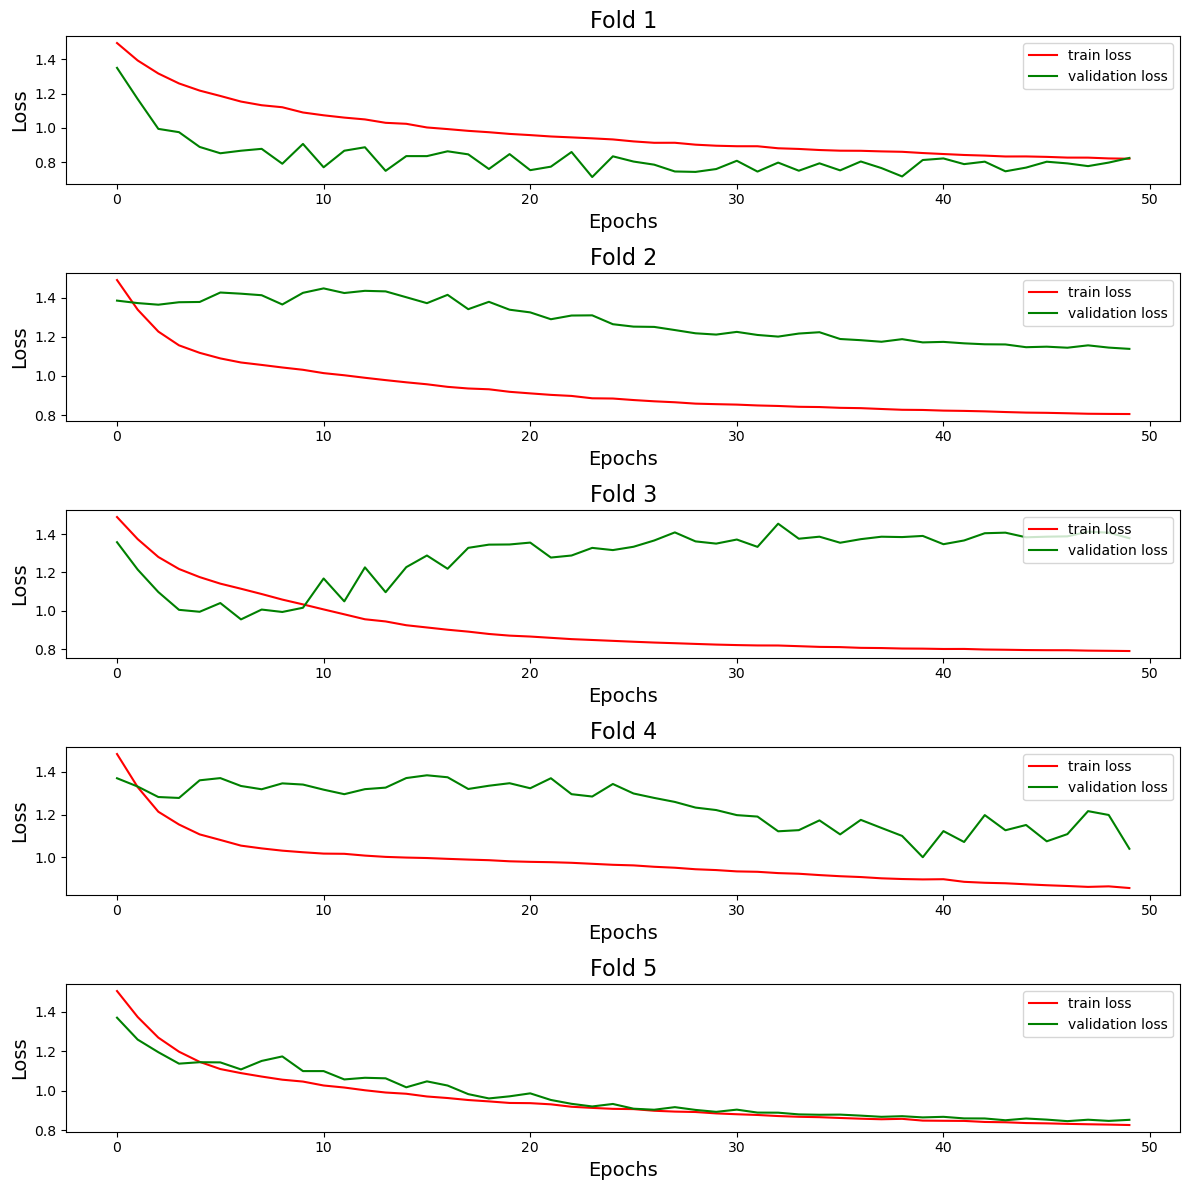

In [32]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.plot(tL[i],'-r')
    ax.plot(vL[i],'-g')
    ax.legend(['train loss', 'validation loss'],loc ="upper right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

plt.tight_layout()
plt.show()

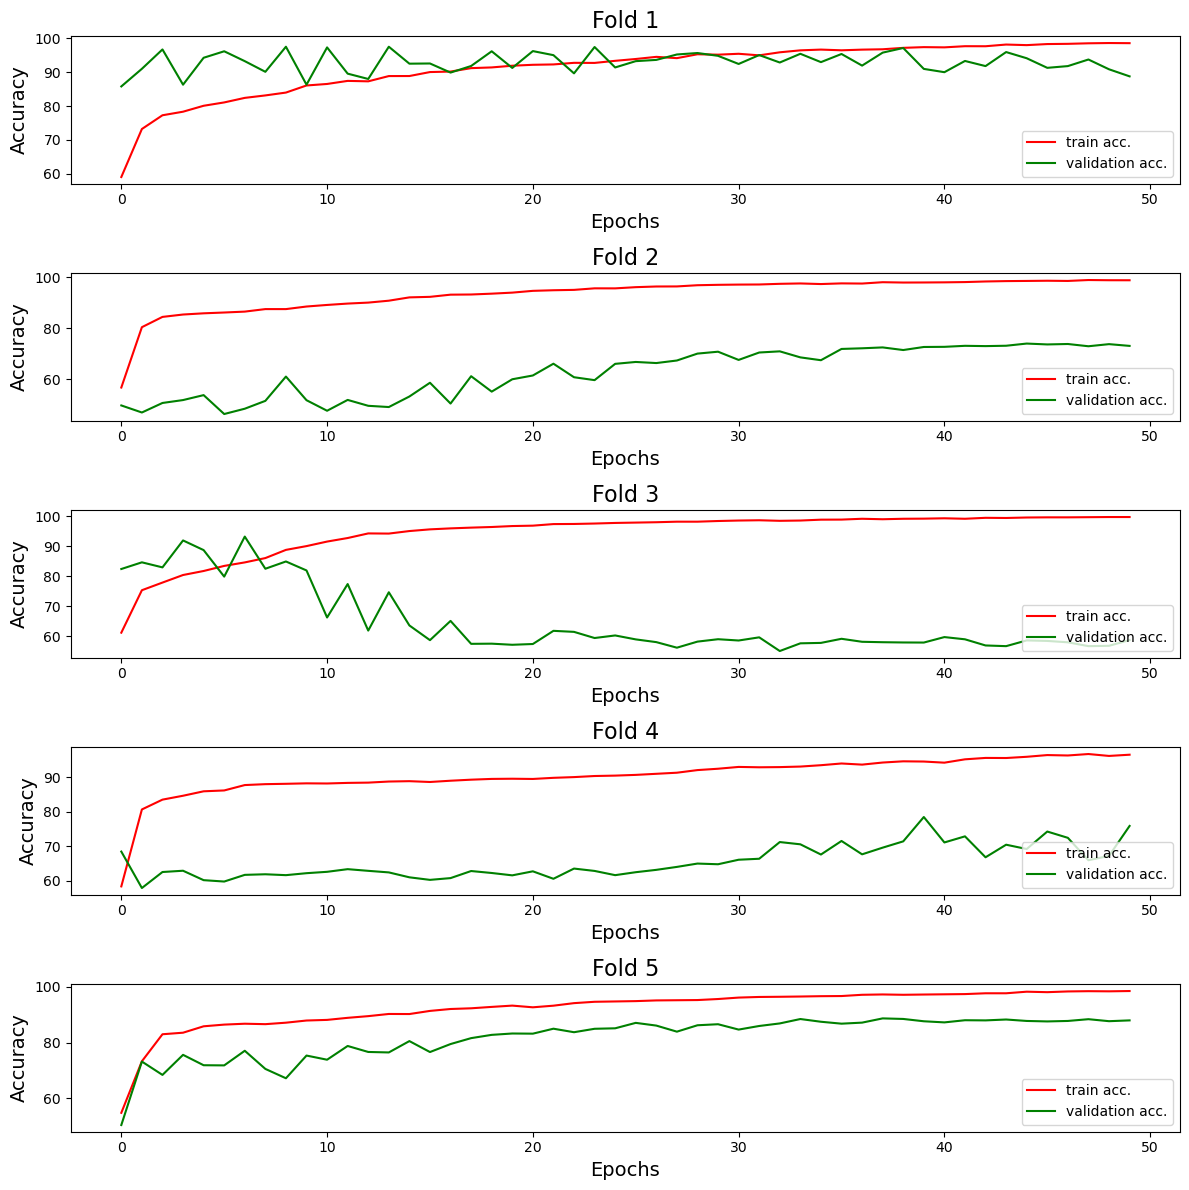

In [33]:
fig, axs = plt.subplots(5,1, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.plot(tAV[i],'-r')
    ax.plot(vAV[i],'-g')
    ax.legend(['train acc.', 'validation acc.'],loc ="lower right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)

plt.tight_layout()
plt.show()

In [34]:
tr = []
pred_gt_tuple = []
for key,value in log_pred_dict.items():
    tr.append(value['trails'])
    pred = torch.cat((value['predicted']),0)
    ground_truth = torch.cat((value['ground truth']),0)
    p = pred.to('cpu').numpy()
    g = ground_truth.to('cpu').numpy()
    print(p.shape)
    print(g.shape)
    pred_gt_tuple.append([p,g])

(470,)
(470,)
(470,)
(470,)
(470,)
(470,)
(470,)
(470,)
(470,)
(470,)


In [35]:
pred.shape

torch.Size([470])

In [36]:
log = {'trials': tr,
       'pred_gt': pred_gt_tuple}

In [37]:
scipy.io.savemat('./logs/Seed53.mat',log)